In [1]:
# Final Project - CSCA 5632 - Unsupervised Algorithms in Machine Learning
# Author: Rafiq Premji

# Introduction/Goal
# For this project I explored using unsupervised algorithms to compress images, with the goal of reducing
# the space required to storage image data while preserving detail. The techniques I used were Principal
# Component Analysis (PCA) and K-Means Clustering. For the image data I chose the CIFAR-10 dataset
# because it's well-known for machine learning tasks and the data is consistent an high-quality. Below is
# the citation/source for CIFAR-10 image data:
# https://www.cs.toronto.edu/~kriz/cifar.html

In [2]:
# load libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from keras.datasets import cifar10
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from skimage.metrics import mean_squared_error

2025-02-03 22:04:54.094935: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-03 22:04:54.097014: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-03 22:04:54.103510: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738645494.114851   62422 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738645494.118142   62422 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-03 22:04:54.130467: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [3]:
# originally I manually downloaded the CIFAR-10 images from the web, but then discovered you can get them
# through the Keras library, so it's loaded from there below:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# CIFAR images are 32x32 pixels in dimension, with 3 values for red, green, blue channels of 0-255 (or 8
# bits). therefore a single uncompressed image is 32x32x3x8 bits = 24,576 bits = 3072 bytes = 3 kilobytes.

# examining the lengths of the datasets
print(f'Train: X {X_train.shape}, y {y_train.shape}')
print(f'Test: X {X_test.shape}, y {y_test.shape}')

# I decided to use only the test dataset because using more than 10,000 images will cause long waits
# while models are training, and I don't need to split my data into train/test since I'm not predicting
# labels.

# text labels for the image categories
cifar_labels = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

Train: X (50000, 32, 32, 3), y (50000, 1)
Test: X (10000, 32, 32, 3), y (10000, 1)


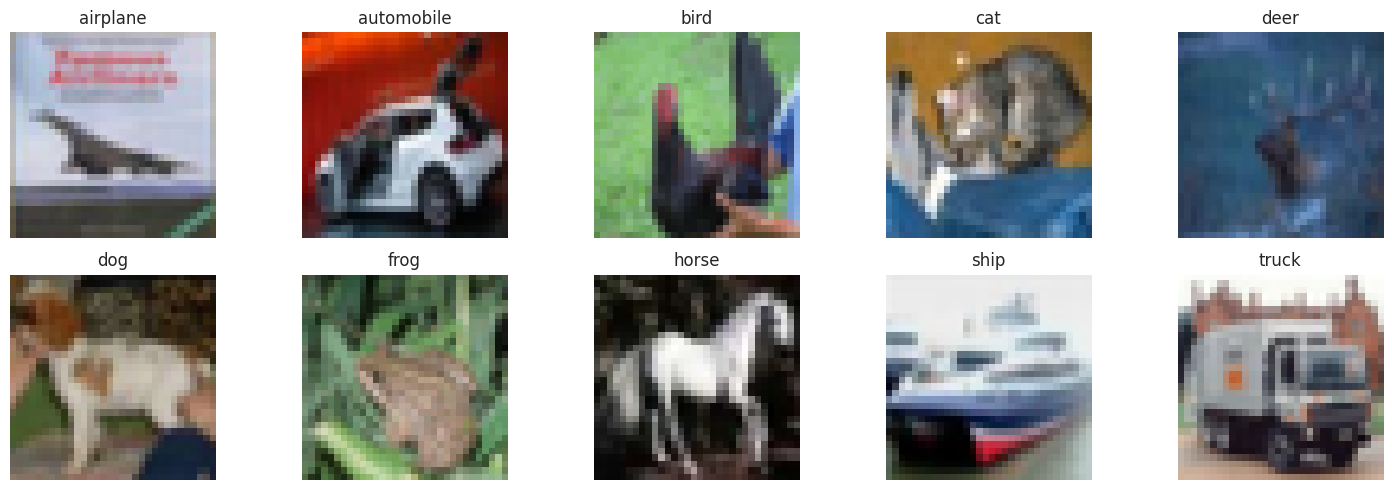

In [4]:
# examine some images from each category to make sure they look ok:
unique_labels = np.unique(y_test)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 5))
for ax, label in zip(axes.flatten(), unique_labels):
    ax.imshow(X_test[y_test.flatten() == label][0])
    ax.set_title(cifar_labels[label])
    ax.axis('off')
plt.tight_layout()

In [5]:
# looks ok, other than being blurry because they are zoomed in on my screen

In [6]:
# flatten the data for visualization and analysis:
X_flat = X_test.reshape(X_test.shape[0], -1)
X_normalized = X_flat / 255.0

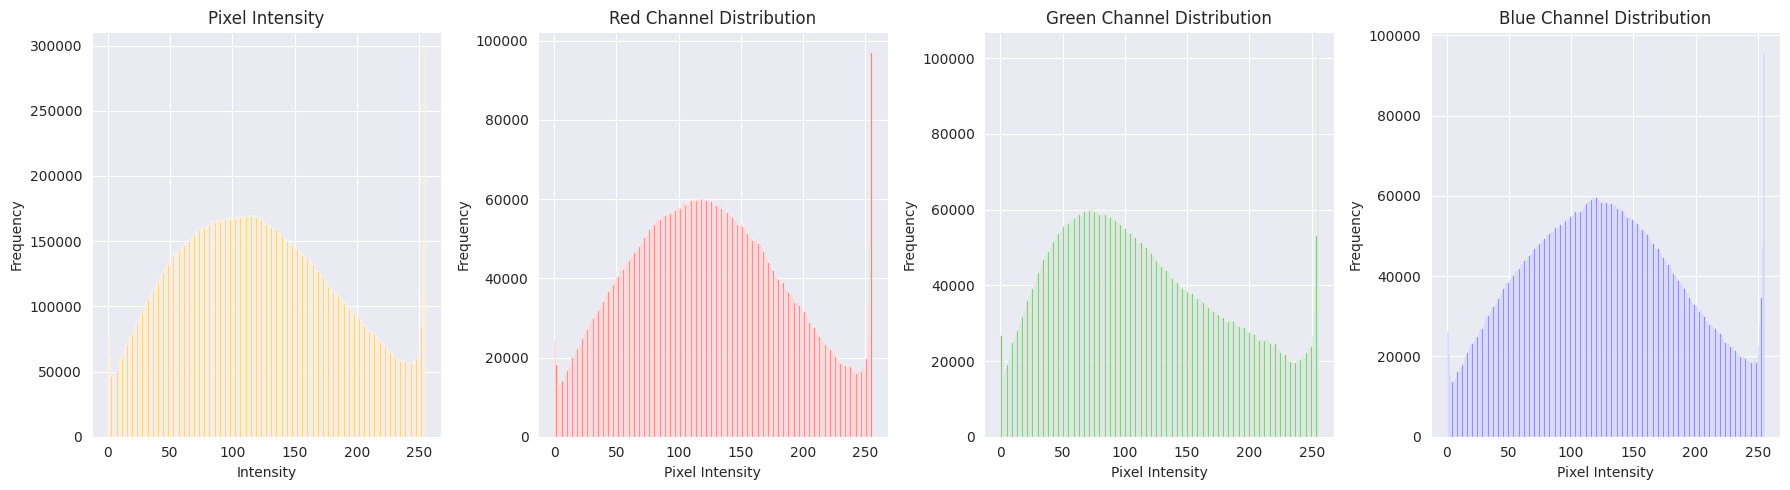

In [7]:
# continue EDA by plotting pixel and color distributions

colors = ['red', 'green', 'blue']
fig, axes = plt.subplots(1, 4, figsize=(18, 5))
axes[0].hist(X_flat.ravel(), bins=256, color='orange', alpha=0.6)
axes[0].set_title(f'Pixel Intensity')
axes[0].set_xlabel('Intensity')
axes[0].set_ylabel('Frequency')
for i, color in enumerate(colors):
    axes[i+1].hist(X_flat[:, i+1::3].ravel(), bins=256, color=color, alpha=0.6)
    axes[i+1].set_title(f'{color.capitalize()} Channel Distribution')
    axes[i+1].set_xlabel('Pixel Intensity')
    axes[i+1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

In [8]:
# the spikes at 0 and 255 are interesting, indicating that most color intensities are completely
# on or off (which could be a result of down-sampling an image with more colors)

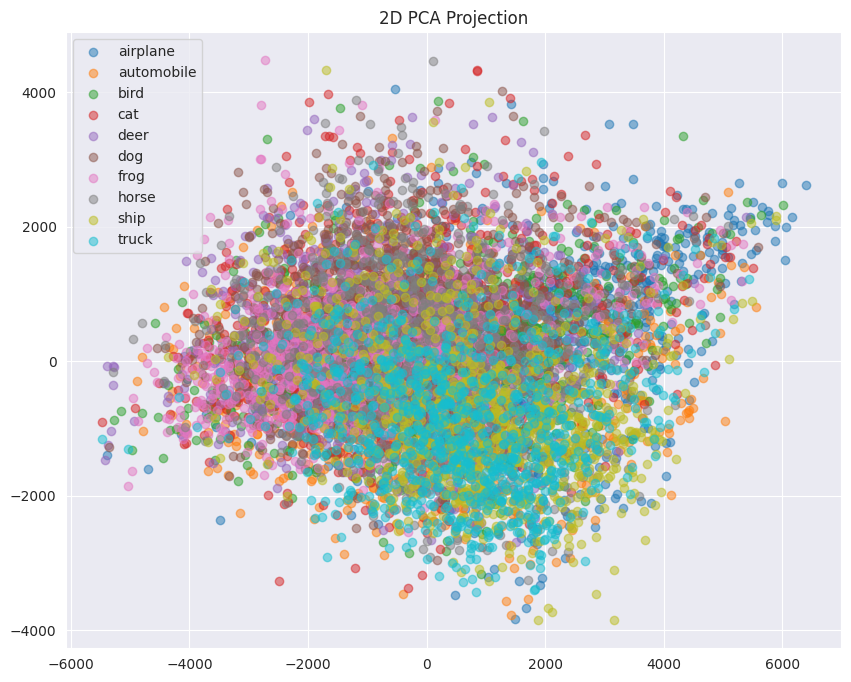

In [9]:
# perform an initial PCA with 2 components to visualize data in a 2d space

pca_2d = PCA(n_components=2)
X_float_pca_2d = pca_2d.fit_transform(X_flat)

plt.figure(figsize=(10, 8))
for label in np.unique(y_test):
    indices = y_test.flatten() == label
    plt.scatter(X_float_pca_2d[indices, 0], X_float_pca_2d[indices, 1], label=cifar_labels[label], alpha=0.5)

plt.title("2D PCA Projection")
plt.legend()
plt.show()

In [10]:
# just looks like one big blob, although some differences may be apparent around the top edge

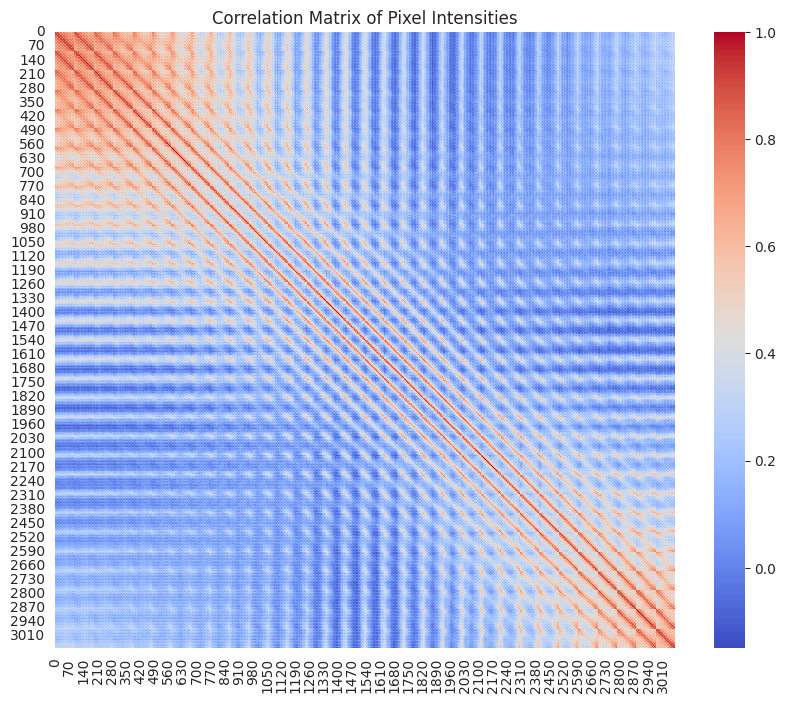

In [11]:
# plot a correlation matrix of pixel intensities for the first 1000 images
image_sample_flat = X_test[:1000].reshape(1000, -1)
correlation_matrix = np.corrcoef(image_sample_flat.T)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Correlation Matrix of Pixel Intensities')
plt.show()

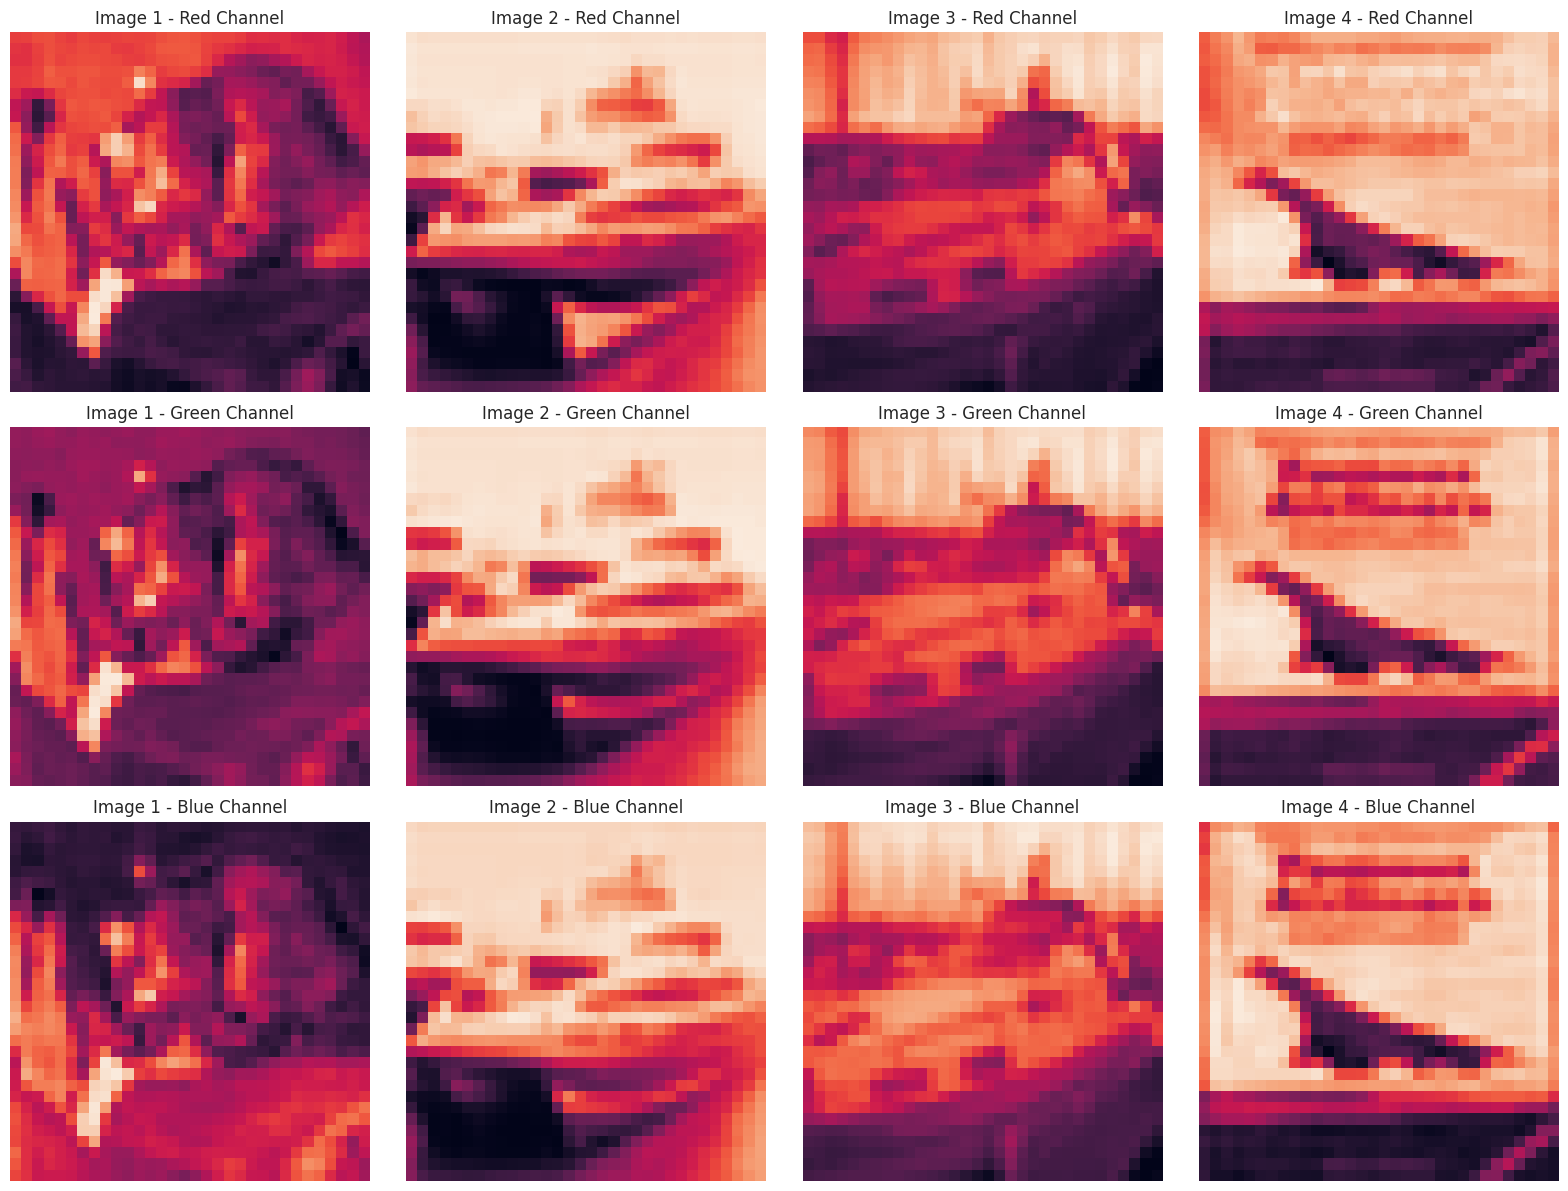

In [12]:
# show color channel data for a few images
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i in range(4):
    image = X_test[i]

    for j, color in enumerate(colors):
        ax = axes[j, i]
        ax.imshow(image[..., j])
        ax.set_title(f'Image {i+1} - {color.capitalize()} Channel')
        ax.axis('off')
plt.tight_layout()
plt.show()

In [13]:
# PCA Model Building / Hyperparameter Tuning

# For the first attempt at image compression, I performed a dimensional reduction using PCA,
# then saw how few vectors could capture the character of the image without too much degradation.

In [14]:
X_normalized.dtype

# The X_normalized data defaults to 8 byte floats, which requires a lot of storage space, so I will
# test different storage types later.

dtype('float64')

Computing Variance for 25 components
Computing Variance for 50 components
Computing Variance for 75 components
Computing Variance for 100 components
Computing Variance for 125 components
Computing Variance for 150 components
Computing Variance for 175 components
Computing Variance for 200 components
Computing Variance for 225 components
Computing Variance for 250 components
Computing Variance for 275 components
Computing Variance for 300 components
Computing Variance for 325 components
Computing Variance for 350 components
Computing Variance for 375 components
Computing Variance for 400 components


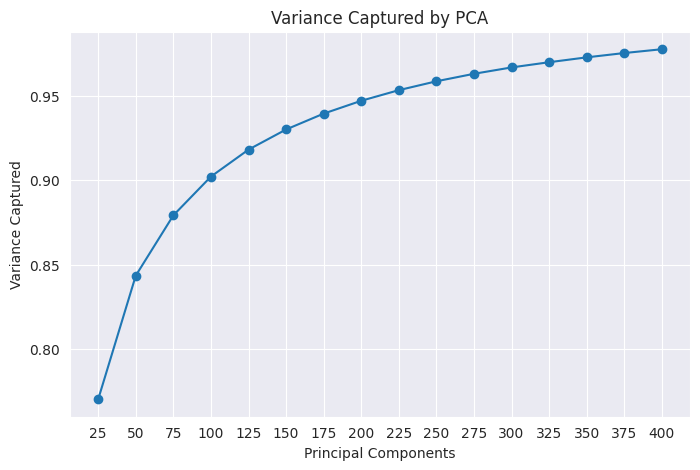

,Components,Variance Captured
0,25,0.770460
1,50,0.843615
2,75,0.879275
3,100,0.902211
4,125,0.918162
5,150,0.930085
6,175,0.939473
7,200,0.947068
8,225,0.953349
9,250,0.958605


In [15]:
# I picked my number of components for PCA compression by benchmarking the variance captured
# for increasing amounts of n_components.

n_components_range = range(25, 401, 25)

components = []
variance_ratios_64 = []

for n_components in n_components_range:
    PCA_64 = PCA(n_components=n_components)
    X_flat_pca_64 = PCA_64.fit_transform(X_normalized)
    components.append(n_components)
    variance_ratios_64.append(np.sum(PCA_64.explained_variance_ratio_))
    print(f"Computing Variance for {n_components} components")

plt.figure(figsize=(8, 5))
plt.plot(components, variance_ratios_64, marker='o', linestyle='-')
plt.title('Variance Captured by PCA')
plt.xlabel('Principal Components')
plt.ylabel('Variance Captured')
plt.xticks(n_components_range)
plt.grid(True)
plt.show()

pd.DataFrame({
    'Components': components,
    'Variance Captured': variance_ratios_64
})

In [16]:
# Decision: I started with 300 components because it captures 97% of the variance and the
# graph is pretty flat at that point

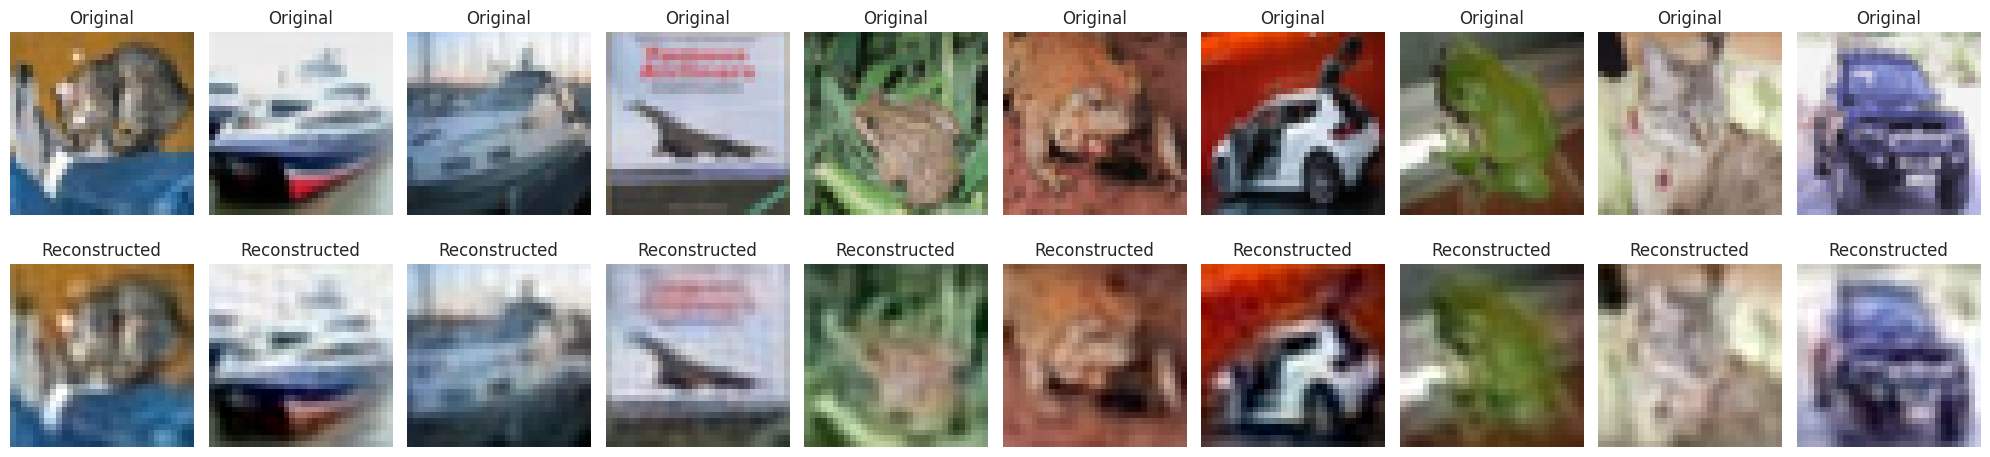

In [17]:
# next I wrote some code which shows original next to reconstructed images to check how they
# compare visually

PCA_64 = PCA(n_components=300)
X_flat_pca_64 = PCA_64.fit_transform(X_normalized)

# invert transforms to reconstruct images
X_flat_reconstructed = PCA_64.inverse_transform(X_flat_pca_64)

# clamp values to be between 0 and 1 (
X_flat_reconstructed_clipped = np.clip(X_flat_reconstructed, 0, 1)

# show original images next to reconstructed
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(20, 5))
for i in range(10):
    # original
    axes[0, i].imshow(X_normalized[i].reshape(32, 32, 3))
    axes[0, i].set_title('Original')
    axes[0, i].axis('off')

    # reconstructed
    axes[1, i].imshow(X_flat_reconstructed_clipped[i].reshape(32, 32, 3))
    axes[1, i].set_title('Reconstructed')
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()


In [18]:
# Looks a bit fuzzy, but the images are very recognizable and I will compare different n_components later

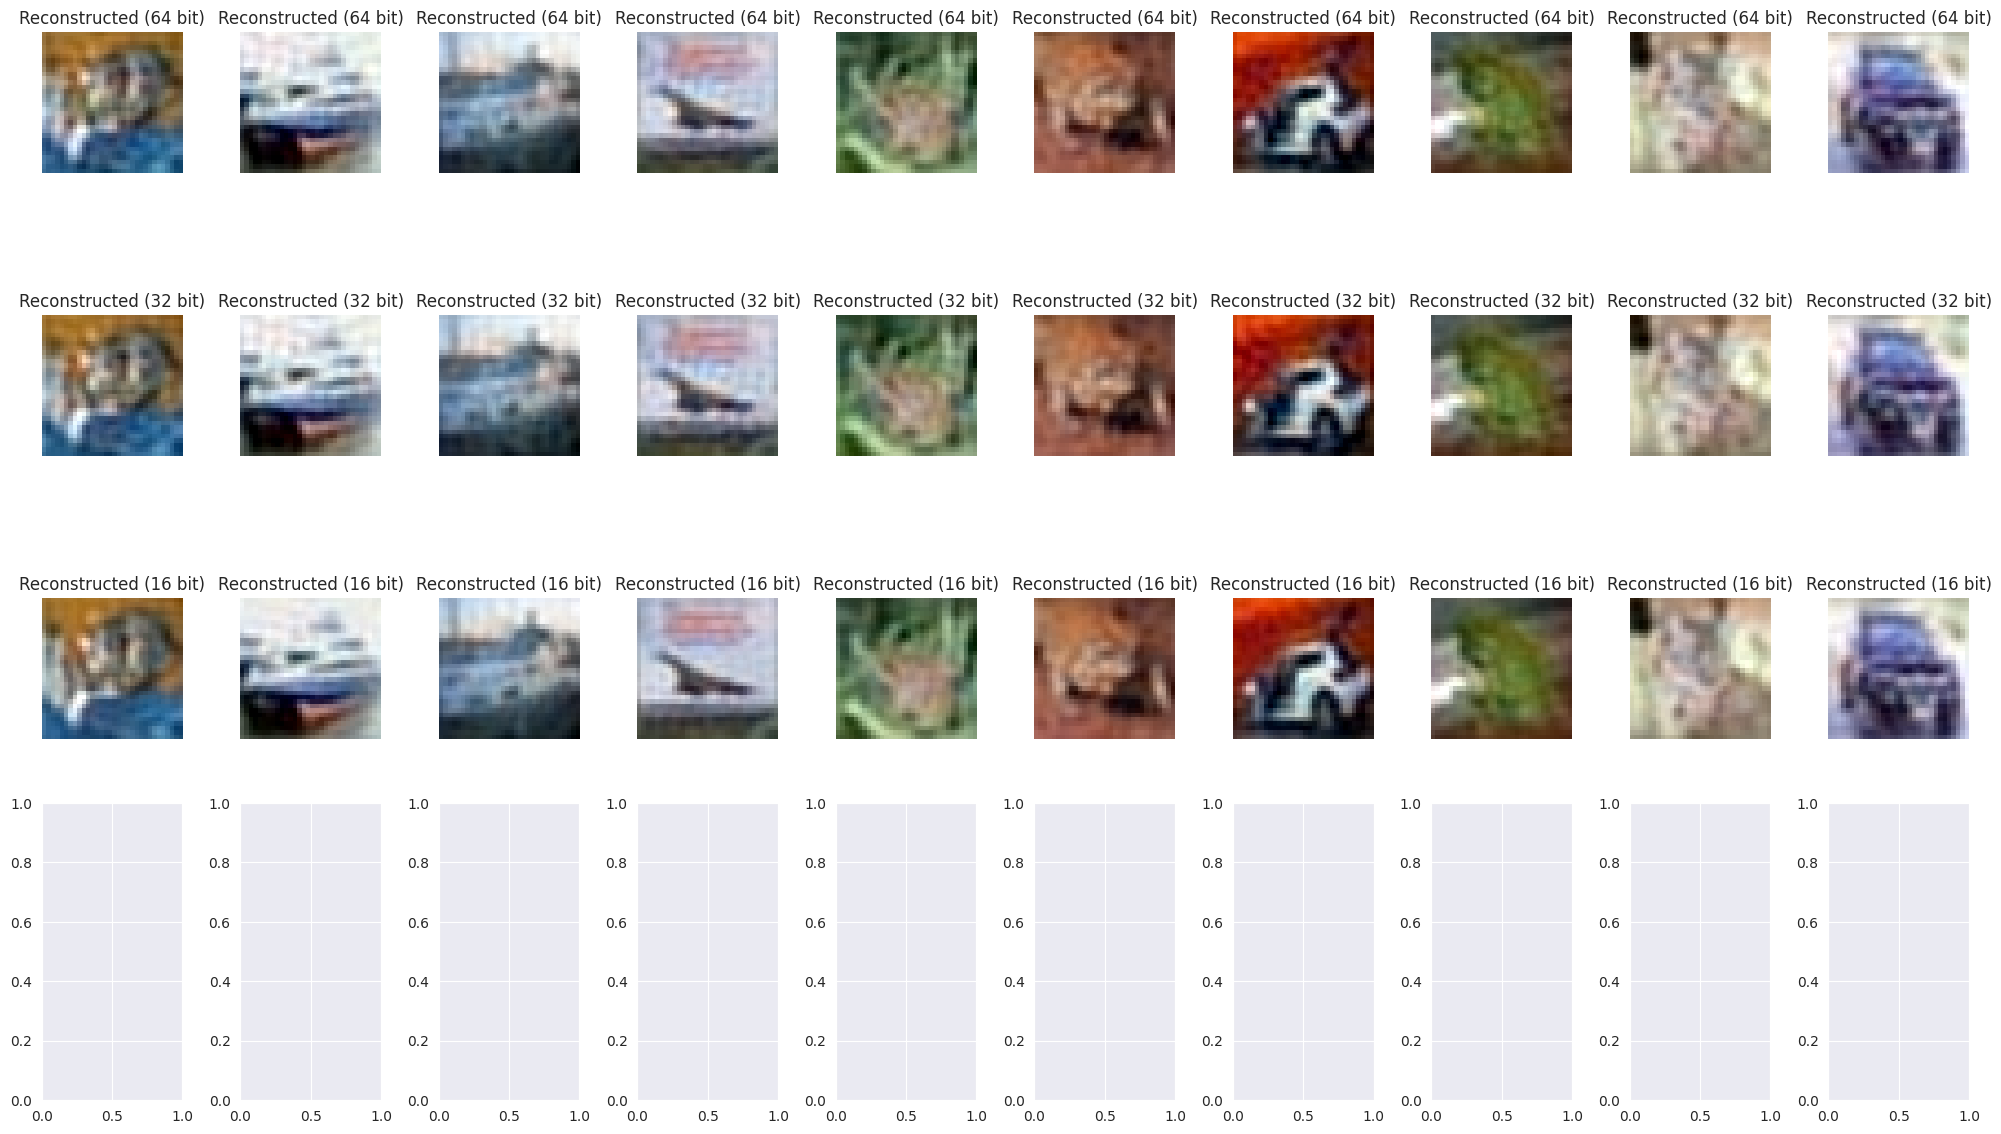

In [19]:
# this code compares results between using a model with 64/32/16 bit (8/4/2 byte)
# floats.

PCA_64 = PCA(n_components=300)
X_flat_pca_64 = PCA_64.fit_transform(X_normalized)
X_flat_pca_32 = PCA_64.fit_transform(X_normalized.astype(np.float32))
X_flat_pca_16 = PCA_64.fit_transform(X_normalized.astype(np.float16))

# invert transforms to reconstruct images
X_flat_reconstructed = PCA_64.inverse_transform(X_flat_pca_64)
X_flat_reconstructed_32 = PCA_64.inverse_transform(X_flat_pca_32)
X_flat_reconstructed_16 = PCA_64.inverse_transform(X_flat_pca_16)

# clamp values to be between 0 and 1
X_flat_reconstructed_clipped = np.clip(X_flat_reconstructed, 0, 1)
X_flat_reconstructed_clipped_32 = np.clip(X_flat_reconstructed_32, 0, 1)
X_flat_reconstructed_clipped_16 = np.clip(X_flat_reconstructed_16, 0, 1)

fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(20, 12))
for i in range(10):
    # 64 bit
    axes[0, i].imshow(X_flat_reconstructed_clipped[i].reshape(32, 32, 3))
    axes[0, i].set_title('Reconstructed (64 bit)')
    axes[0, i].axis('off')

    # 32 bit
    axes[1, i].imshow(X_flat_reconstructed_clipped_32[i].reshape(32, 32, 3))
    axes[1, i].set_title('Reconstructed (32 bit)')
    axes[1, i].axis('off')

    # 16 bit
    axes[2, i].imshow(X_flat_reconstructed_clipped_16[i].reshape(32, 32, 3))
    axes[2, i].set_title('Reconstructed (16 bit)')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

In [20]:
# There's surprisingly little variance between the images, so a lot of space can be saved by using lower precision floats

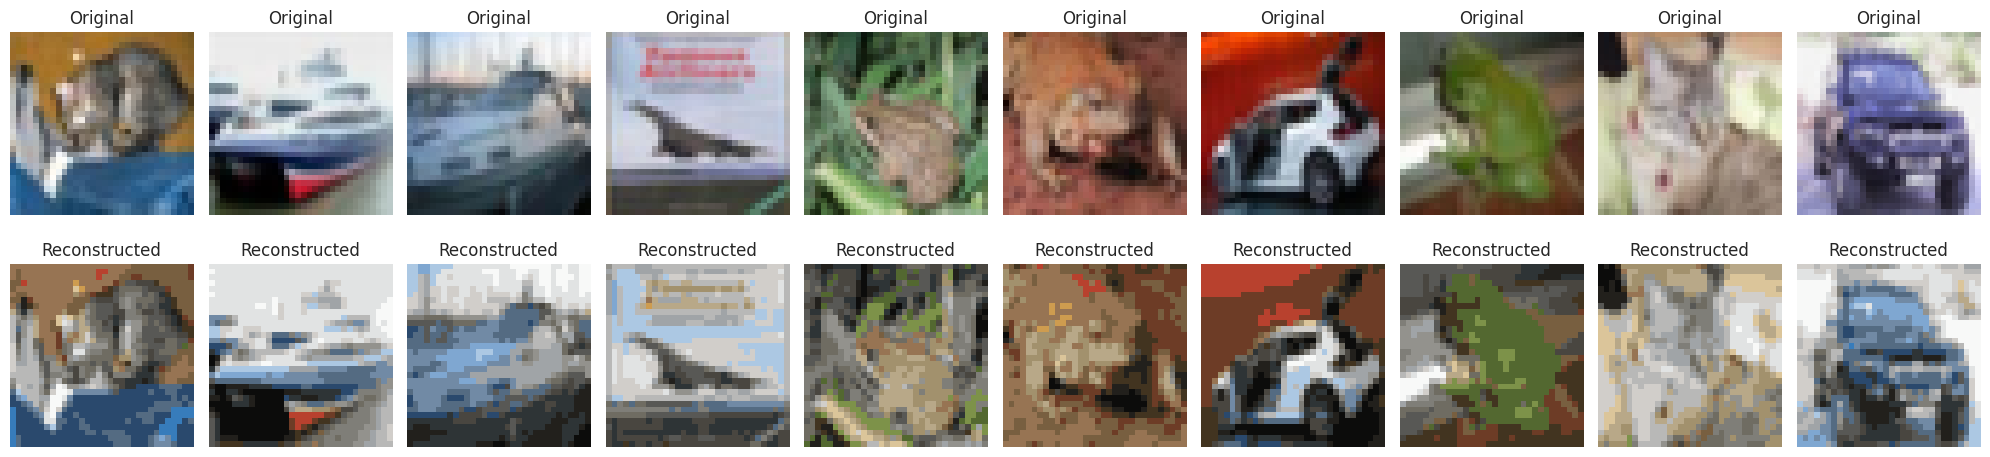

In [21]:
# next I compared PCA against a different unsupervised model, and chose K-Means as a method of compressing
# the color space. I will analyze the actual compression ratio of both methods at the end of this notebook.

# basic implementation of K-Means:
kmeans = KMeans(n_clusters=30)
kmeans.fit(X_normalized.reshape(-1, 3))
compressed_palette = kmeans.cluster_centers_[kmeans.labels_].reshape(X_normalized.shape)
X_test_reconstructed_kmeans = np.clip(compressed_palette, 0, 1)

fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(20, 5))
for i in range(10):
    # original
    axes[0, i].imshow(X_normalized[i].reshape(32, 32, 3))
    axes[0, i].set_title('Original')
    axes[0, i].axis('off')

    # reconstructed
    axes[1, i].imshow(X_test_reconstructed_kmeans[i].reshape(32, 32, 3))
    axes[1, i].set_title('Reconstructed')
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()

In [22]:
# this looks pretty good, and has a "retro gif" quality to it.

40 4
n_components: 40
n_clusters: 4


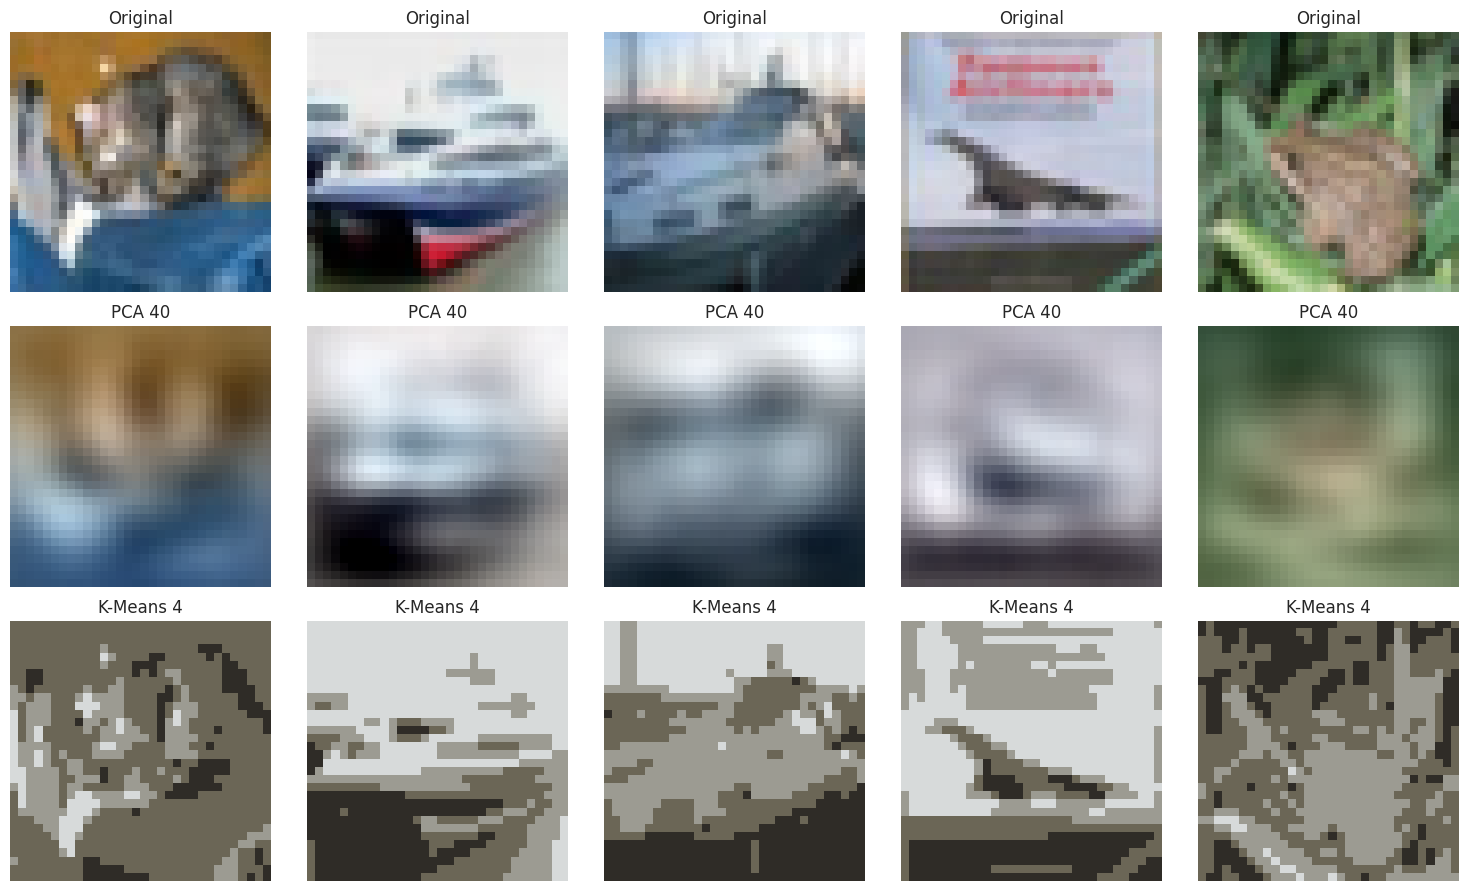

80 8
n_components: 80
n_clusters: 8


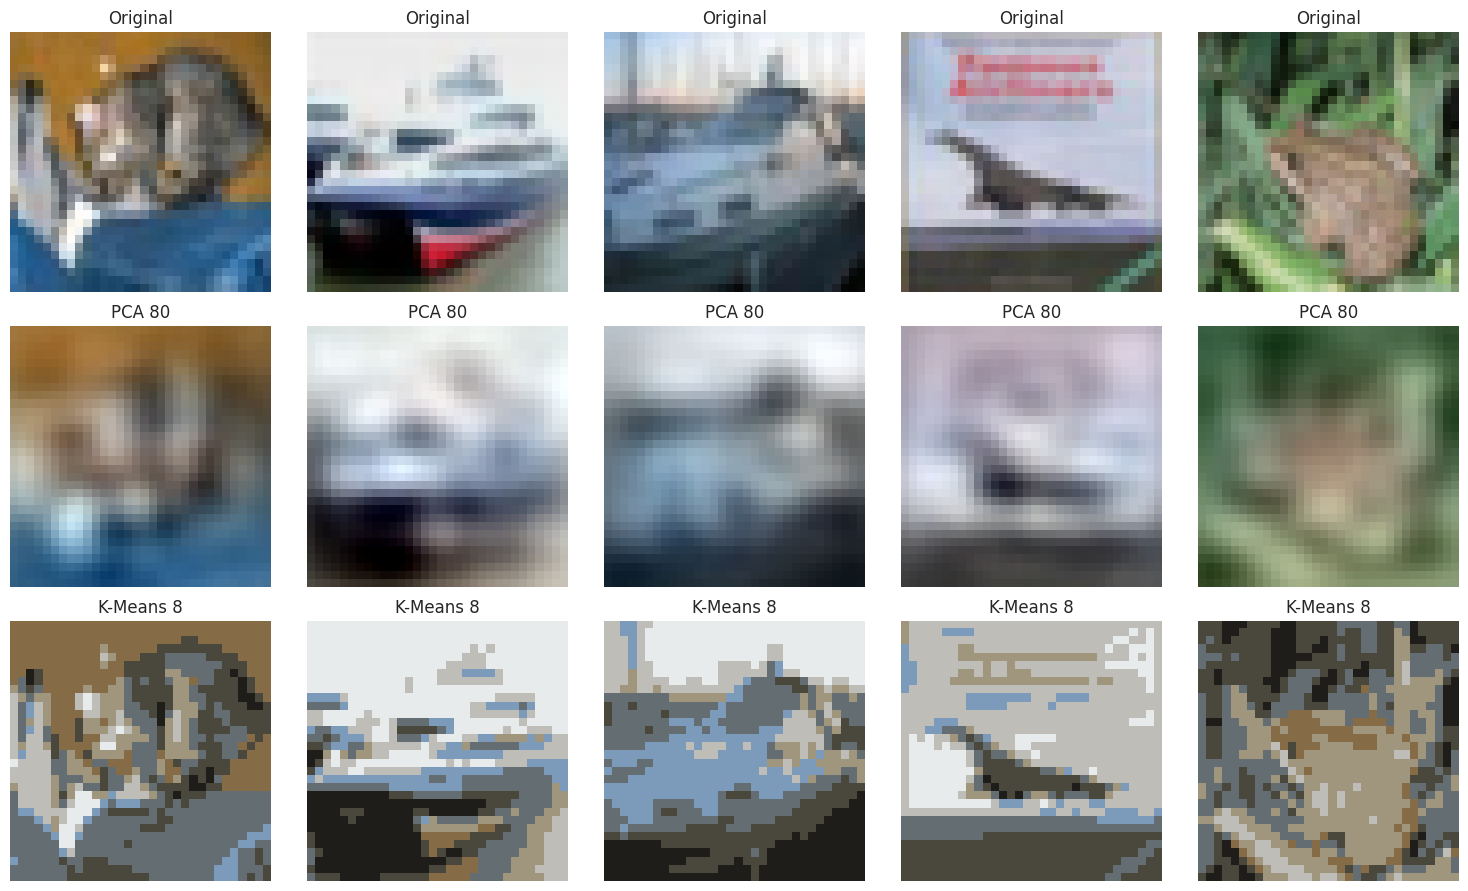

120 12
n_components: 120
n_clusters: 12


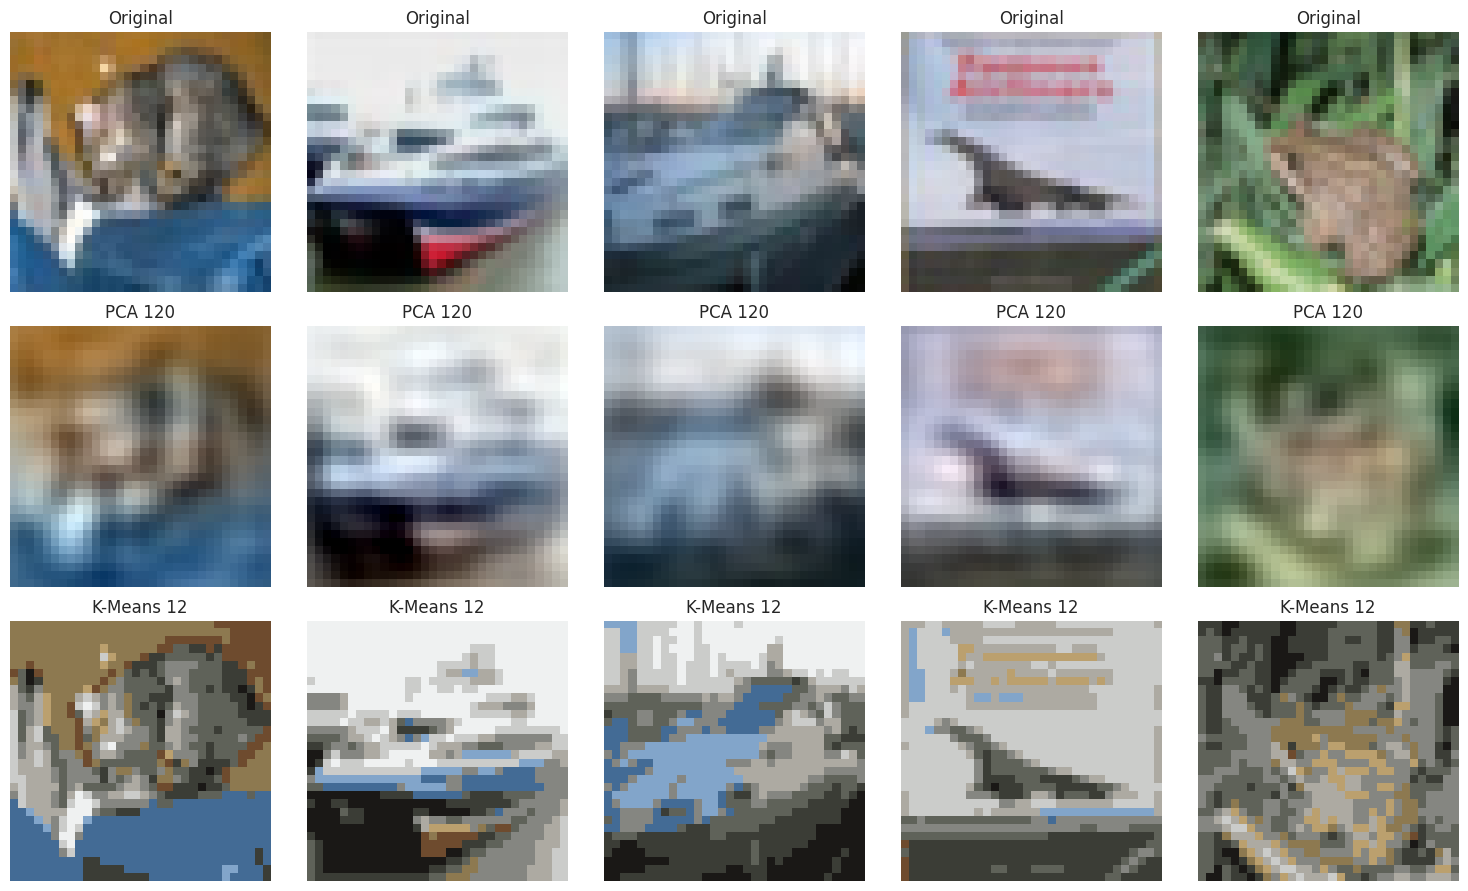

160 16
n_components: 160
n_clusters: 16


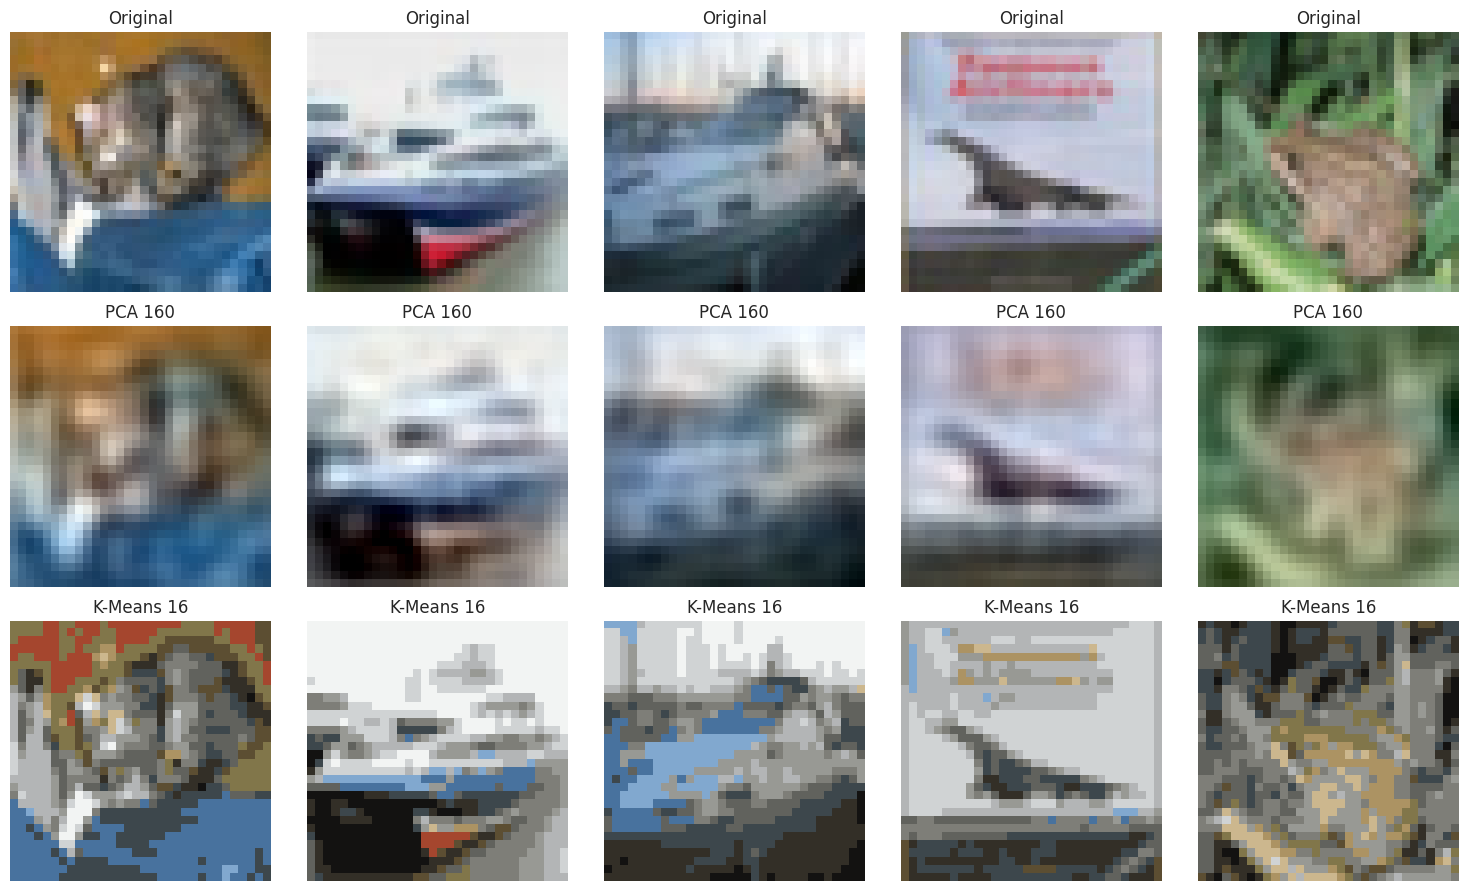

200 20
n_components: 200
n_clusters: 20


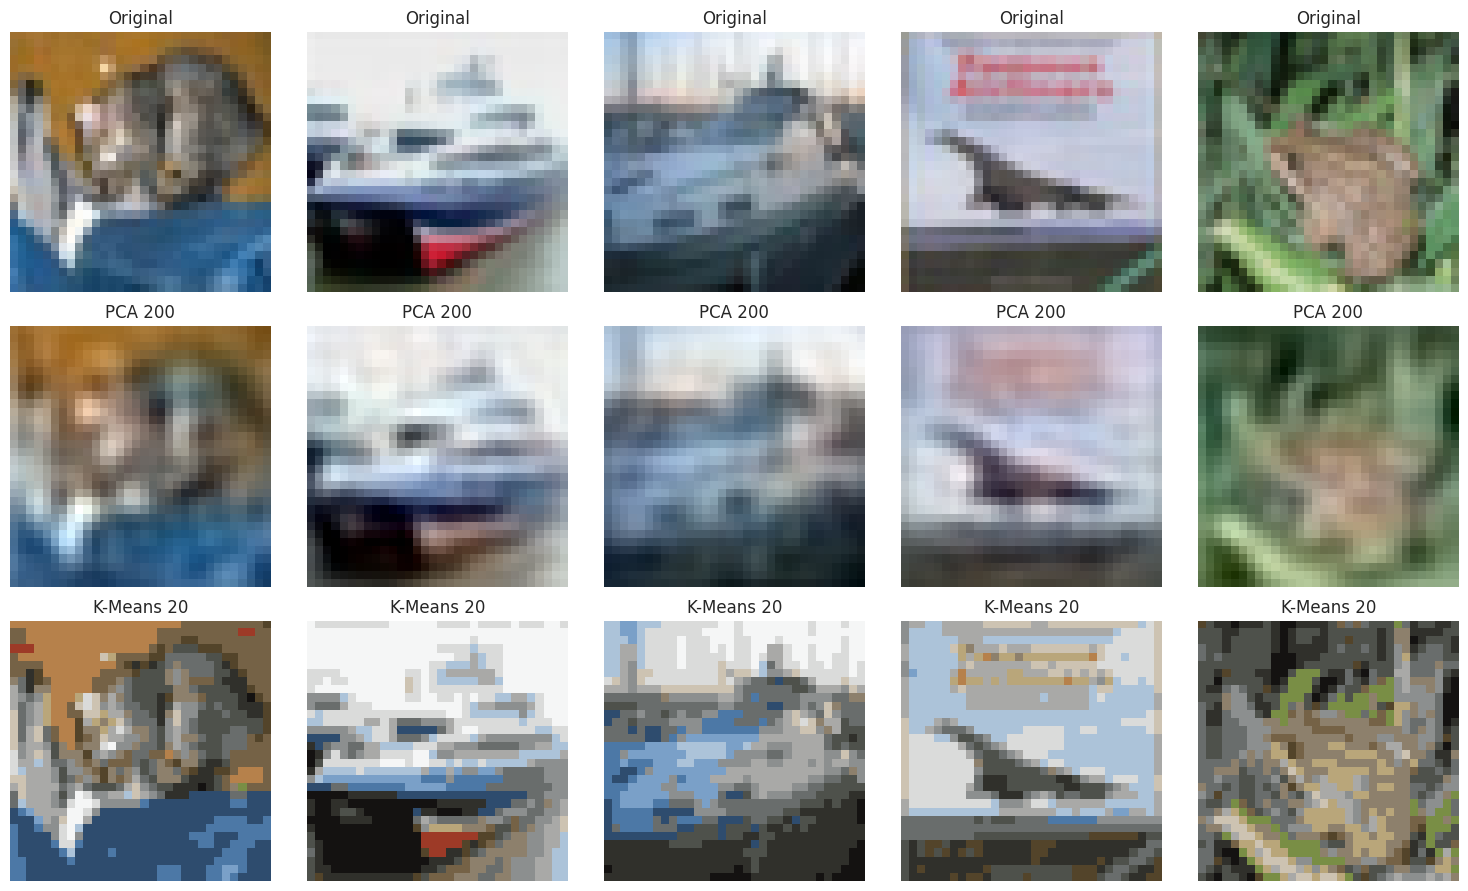

240 24
n_components: 240
n_clusters: 24


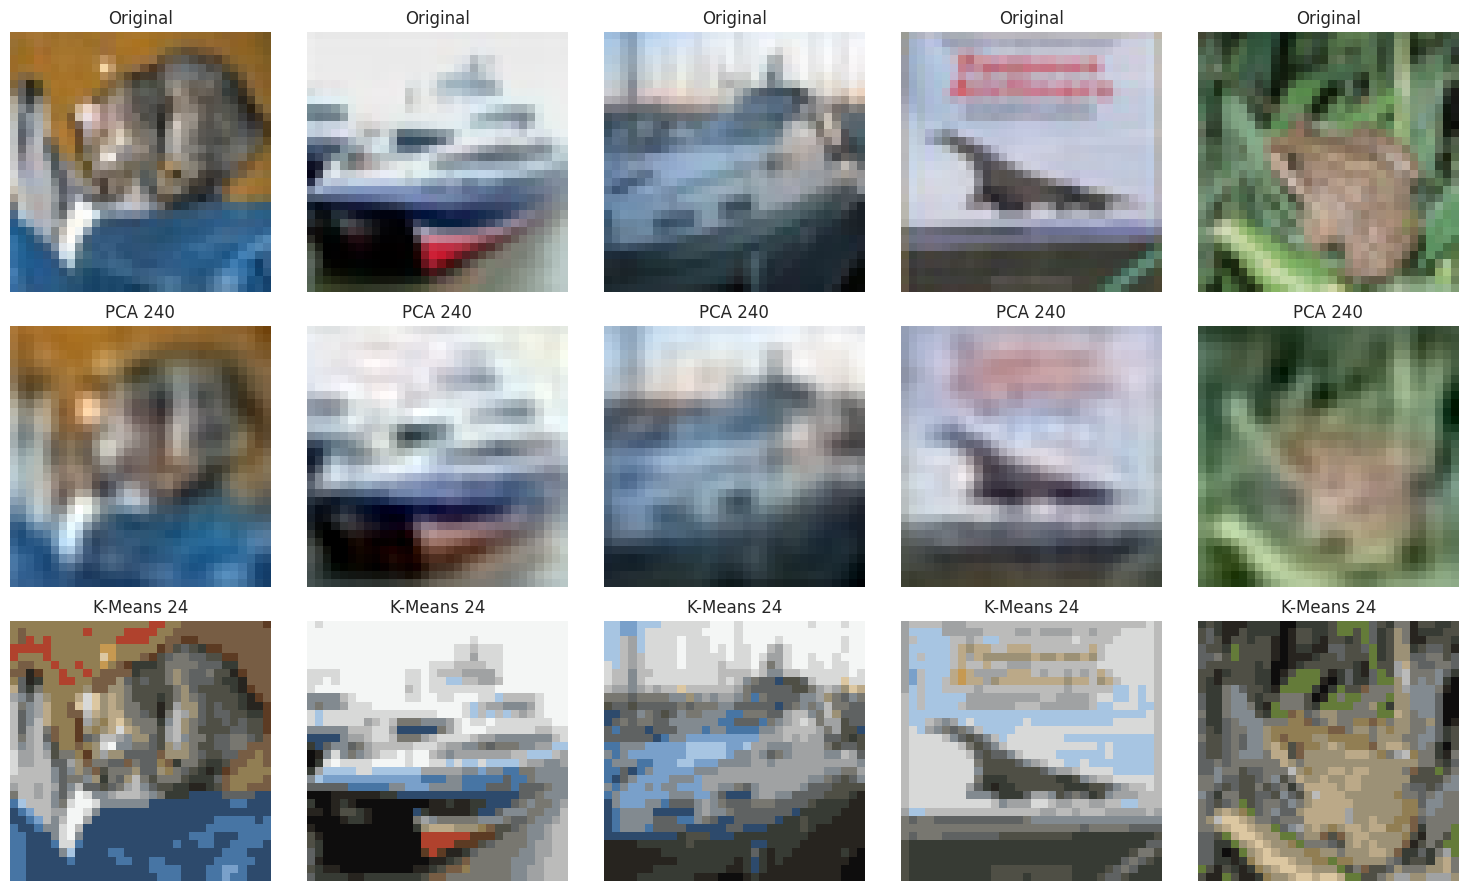

280 28
n_components: 280
n_clusters: 28


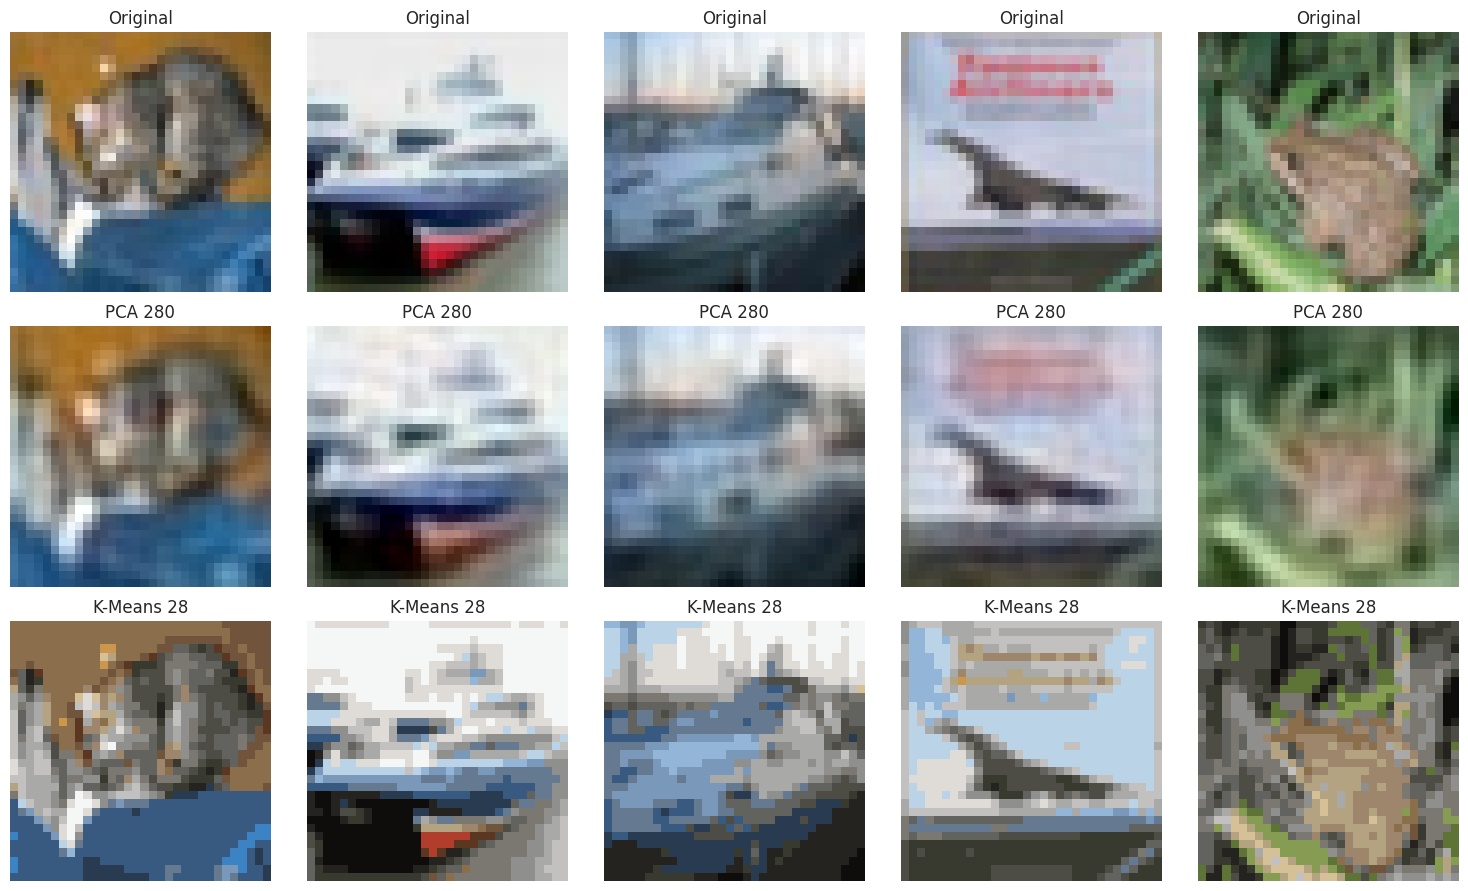

320 32
n_components: 320
n_clusters: 32


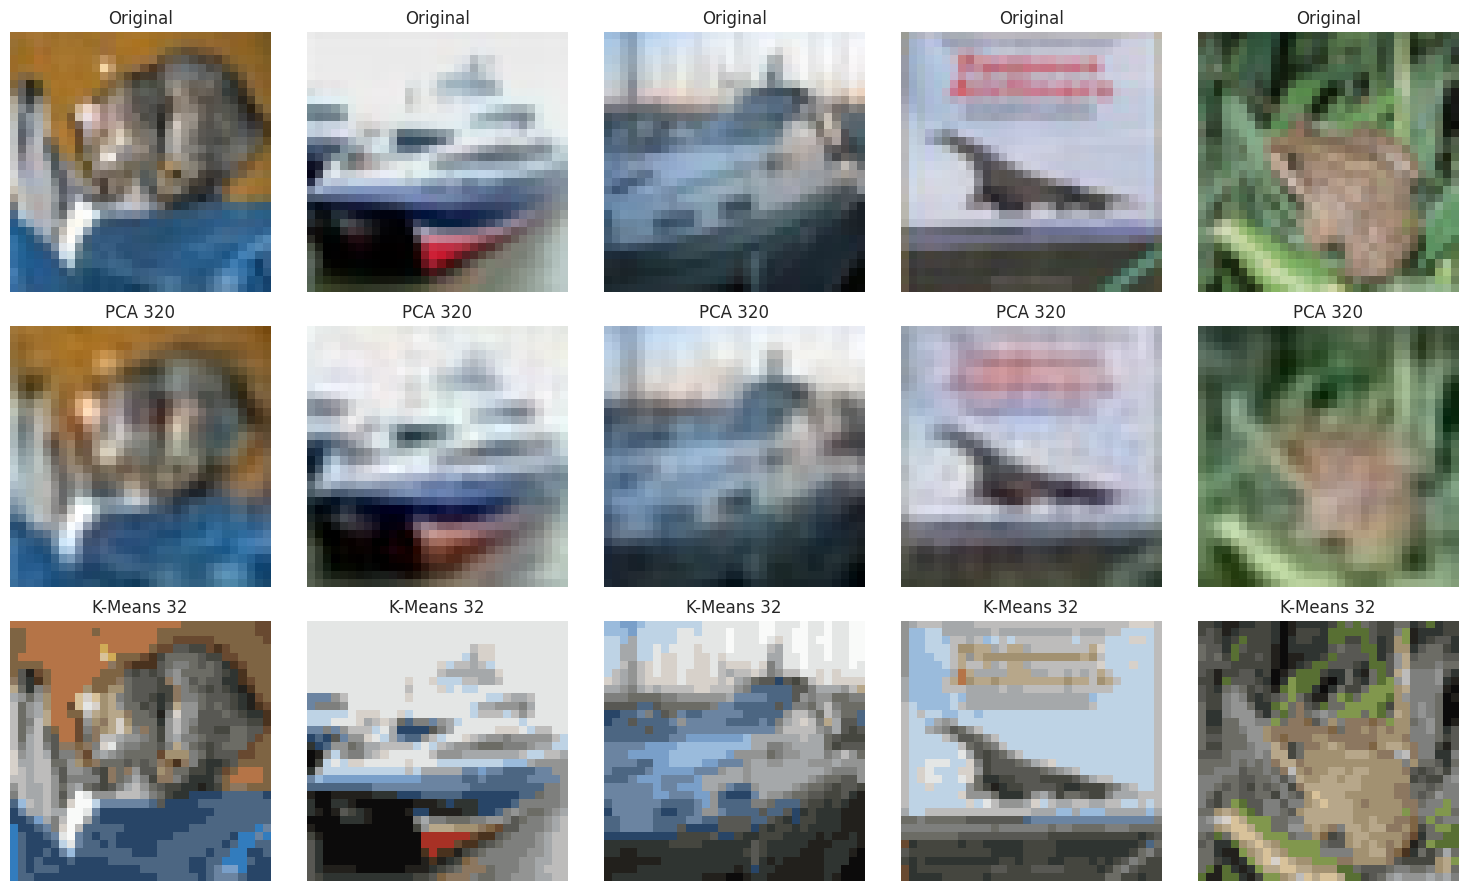

360 36
n_components: 360
n_clusters: 36


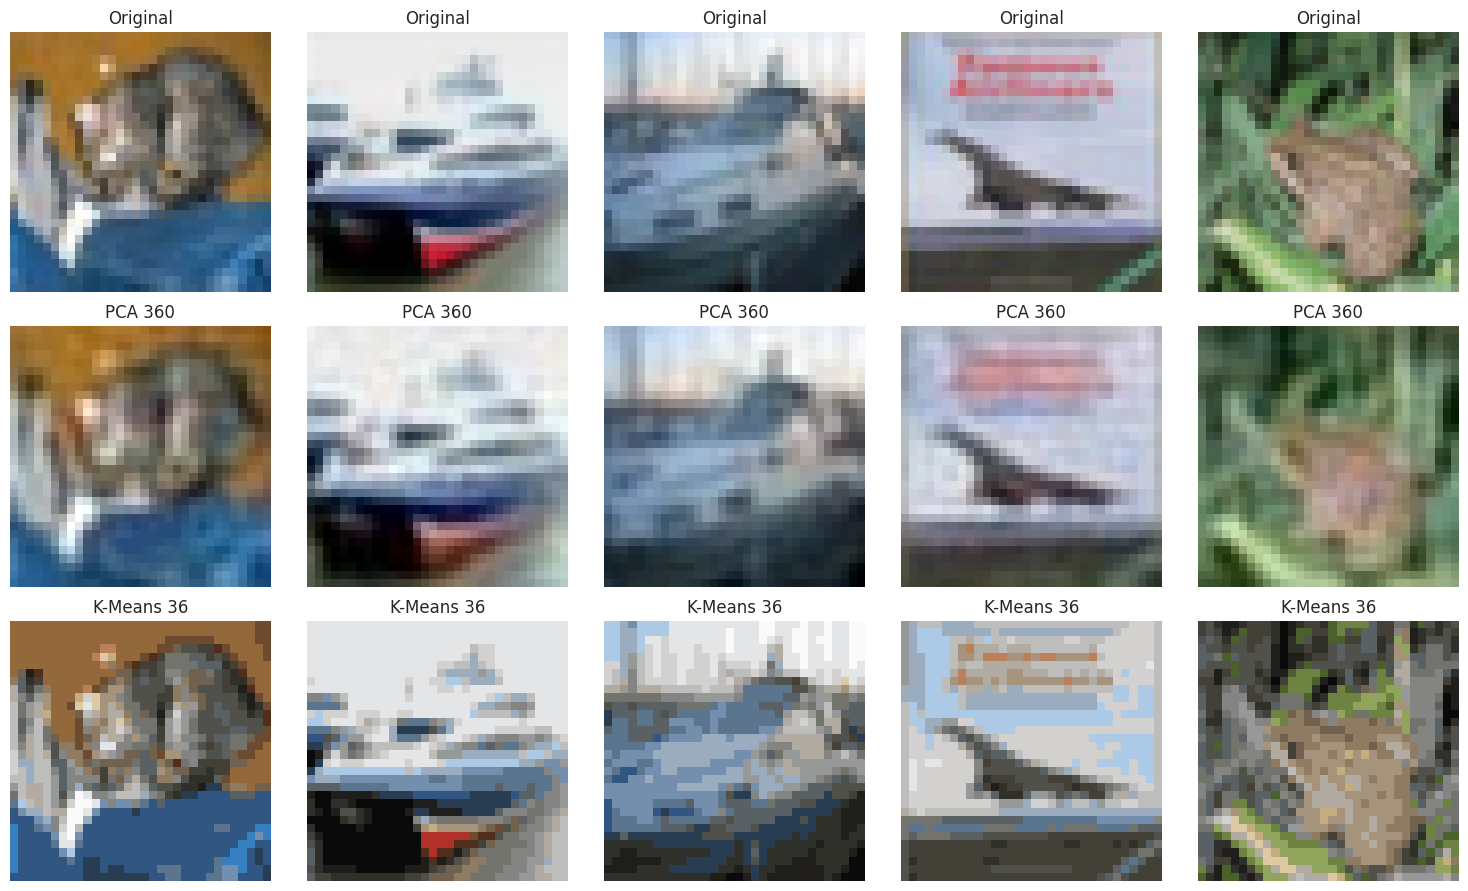

400 40
n_components: 400
n_clusters: 40


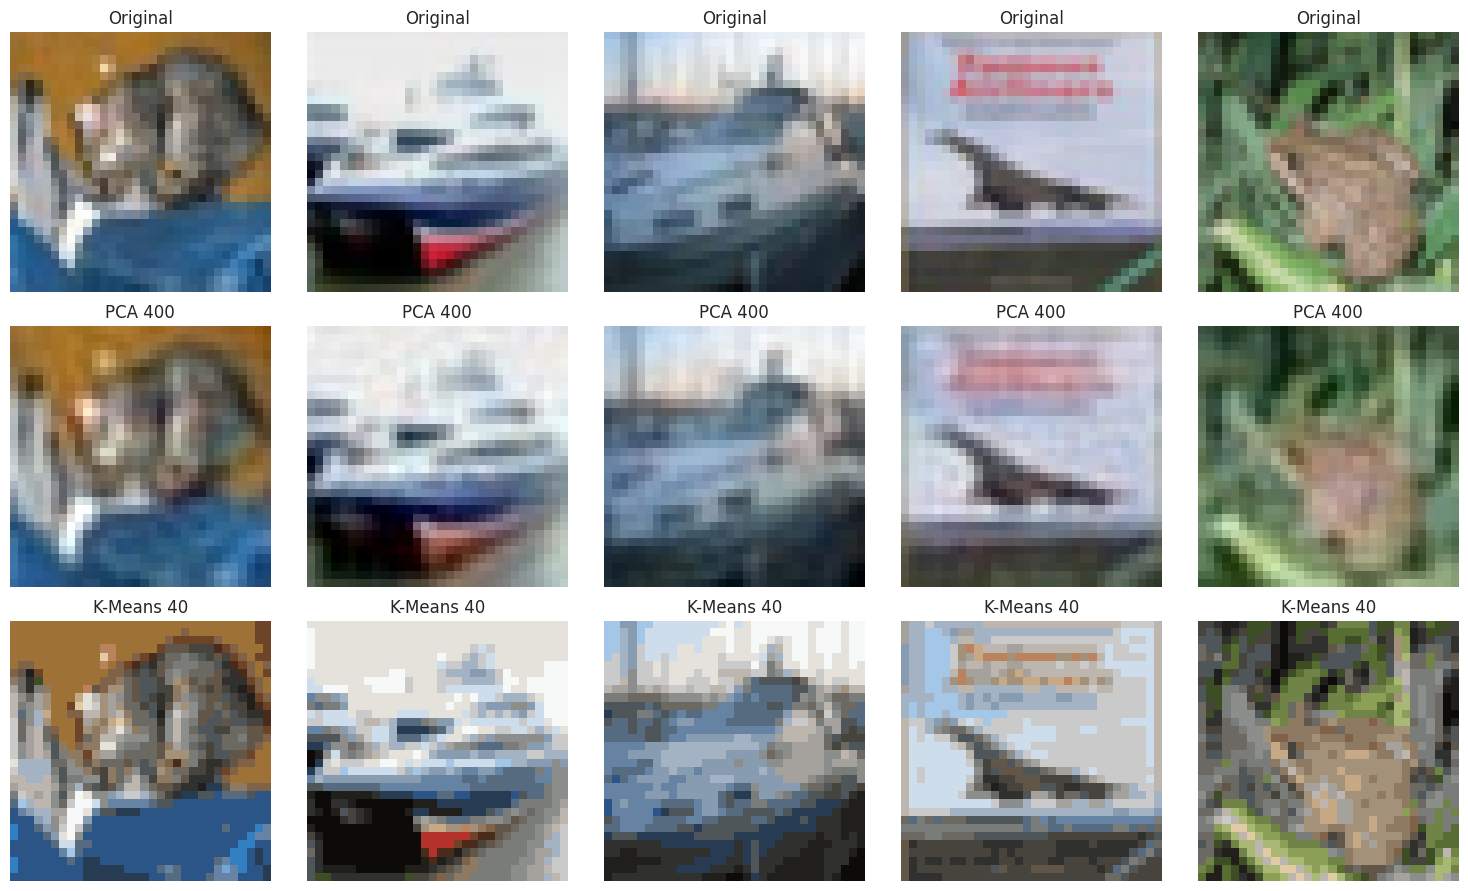

,n_components,method,MSE,PSNR
0,40,PCA,0.011,19.632
1,4,K-Means,0.010,19.821
2,80,PCA,0.007,21.512
3,8,K-Means,0.006,22.222
4,120,PCA,0.005,22.865
5,12,K-Means,0.004,23.578
6,160,PCA,0.004,23.961
7,16,K-Means,0.004,24.551
8,200,PCA,0.003,24.916
9,20,K-Means,0.003,25.187


In [23]:
# Finally, after proving that both concepts work, I benchmarked them against each other. based on how
# long the models took to run, it seemed fair to use about 1/10 as many K-Means clusters as PCA
# n_components. To get an objective measure of how each model performed, I calculated the MSE and
# PSNR (Peak Signal-to-Noise Ratio, higher values are better) against the original images.

results = []

# peak signal-to-noise ratio (PSNR)
def calculate_psnr(original, reconstructed):
    original = np.clip(original, 0, 1)
    reconstructed = np.clip(reconstructed, 0, 1)
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:
        return float('inf')  # No error, PSNR is infinite
    max_pixel_value = 1.0
    psnr = 20 * np.log10(max_pixel_value / np.sqrt(mse))
    return psnr

def process_and_plot(pca_components, kmeans_clusters):
    # PCA
    print(f'n_components: {pca_components}')
    pca = PCA(n_components=pca_components)
    X_flat_pca = pca.fit_transform(X_normalized)
    X_flat_reconstructed_pca = pca.inverse_transform(X_flat_pca)
    X_flat_reconstructed_pca_clipped = np.clip(X_flat_reconstructed_pca, 0, 1)

    mse_pca = mean_squared_error(X_normalized, X_flat_reconstructed_pca)
    psnr_pca = calculate_psnr(X_normalized, X_flat_reconstructed_pca_clipped)

    results.append({
        'n_components': pca_components,
        'method': 'PCA',
        'MSE': round(mse_pca,3),
        'PSNR': round(psnr_pca,3),
    })

    # K-Means
    print(f'n_clusters: {kmeans_clusters}')
    kmeans = KMeans(n_clusters=kmeans_clusters)
    kmeans.fit(X_normalized.reshape(-1, 3))
    compressed_palette = kmeans.cluster_centers_[kmeans.labels_].reshape(X_normalized.shape)
    X_flat_reconstructed_kmeans = np.clip(compressed_palette, 0, 1)

    mse_kmeans = mean_squared_error(X_normalized, X_flat_reconstructed_kmeans)
    psnr_kmeans = calculate_psnr(X_normalized, X_flat_reconstructed_kmeans)

    results.append({
        'n_components': kmeans_clusters,
        'method': 'K-Means',
        'MSE': round(mse_kmeans,3),
        'PSNR': round(psnr_kmeans,3),
    })

    # Plotting
    fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 9))
    for i in range(5):
        axes[0, i].imshow(X_normalized[i].reshape(32, 32, 3))
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')

        axes[1, i].imshow(X_flat_reconstructed_pca_clipped[i].reshape(32, 32, 3))
        axes[1, i].set_title(f'PCA {pca_components}')
        axes[1, i].axis('off')

        axes[2, i].imshow(X_flat_reconstructed_kmeans[i].reshape(32, 32, 3))
        axes[2, i].set_title(f'K-Means {kmeans_clusters}')
        axes[2, i].axis('off')

    plt.tight_layout()
    plt.show()

for pca_components in range(40,401,40):
    print(pca_components, int(pca_components/10))
    process_and_plot(pca_components, int(pca_components/10))

pd.DataFrame(results)

In [24]:
# PCA and K-Means score extremely close in MSE and PSNR for equivalent n_components, but
# PCA has a slight edge overall.

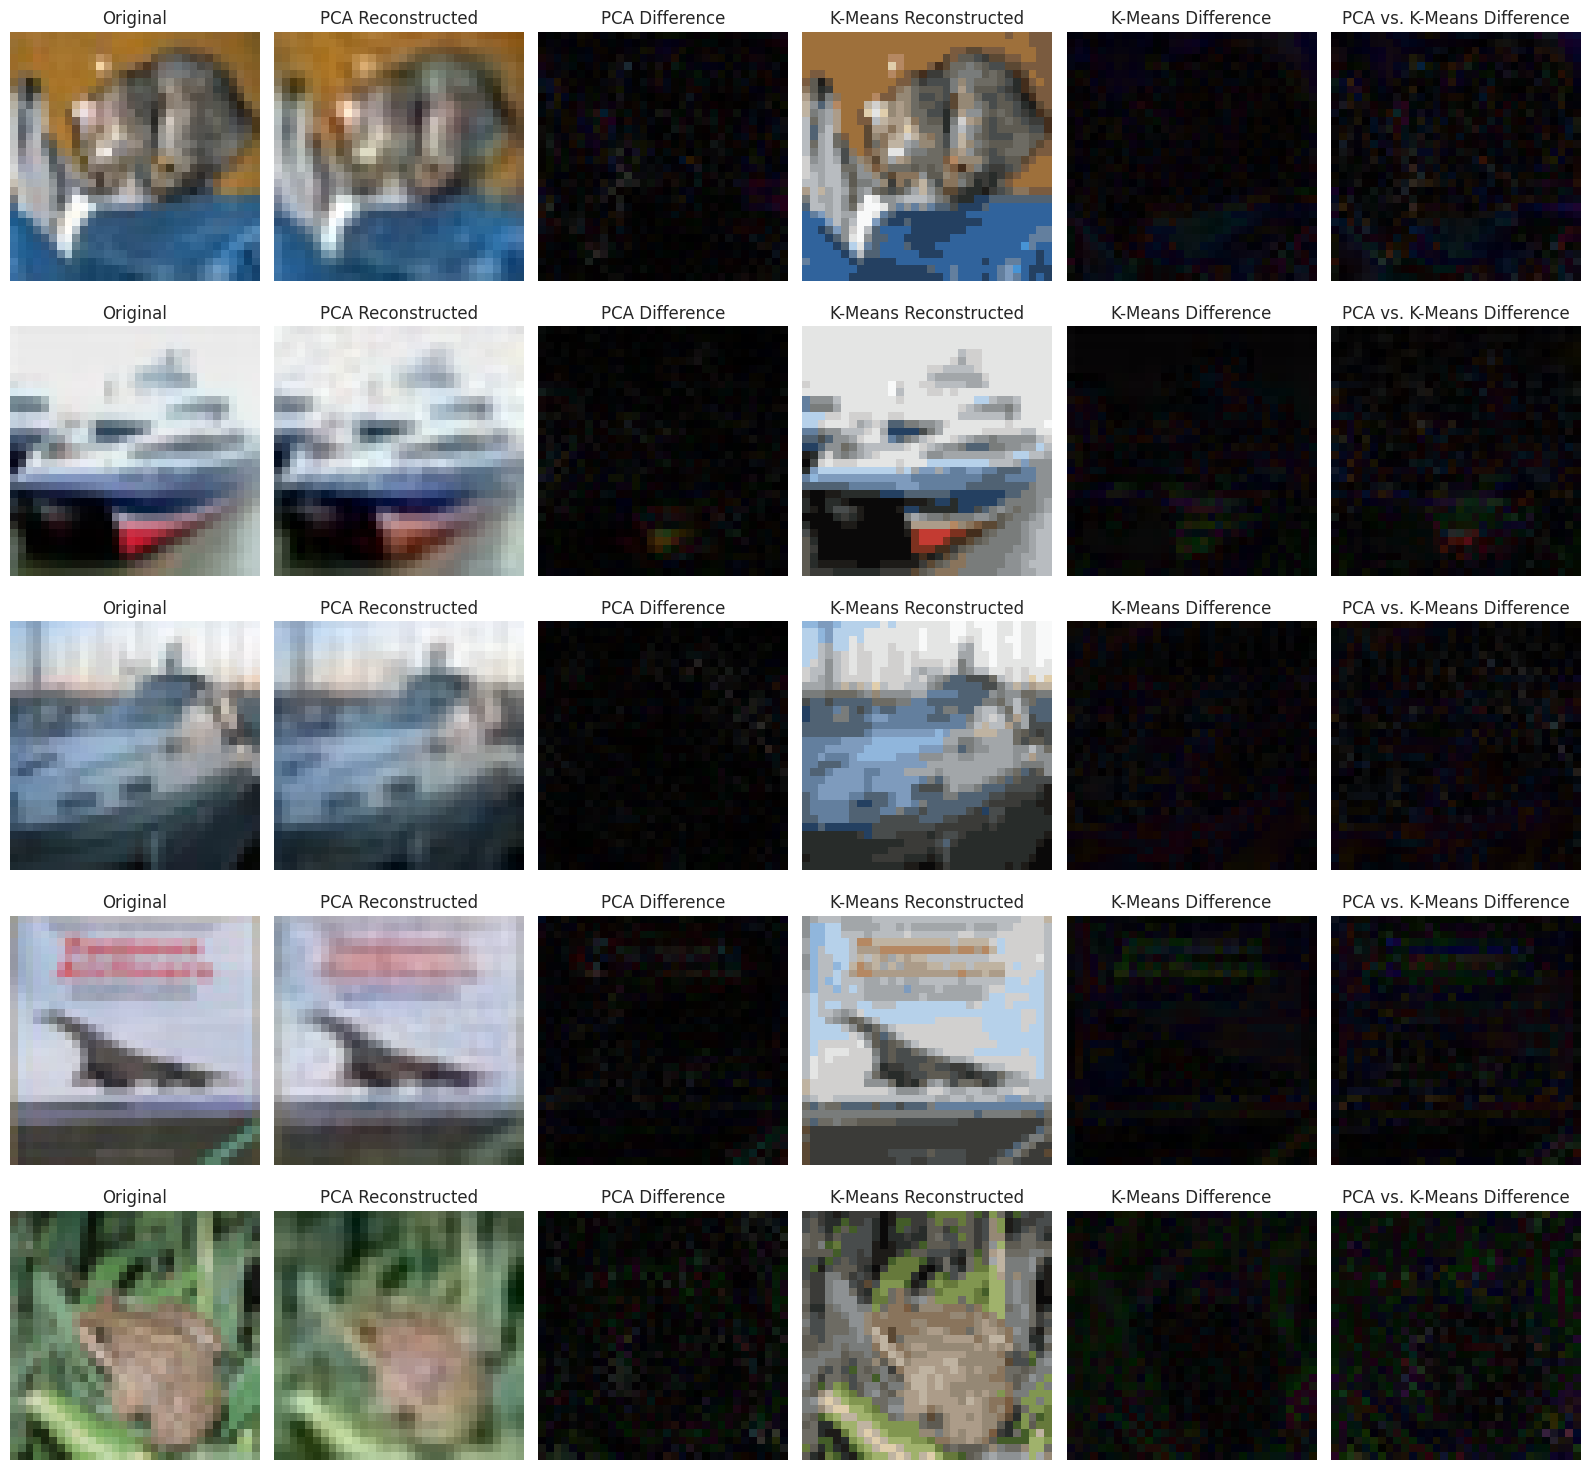

In [25]:
# lastly, I visualized the differences between PCA/KMeans images because I was curious
# how they differed

PCA_64 = PCA(n_components=400)
X_flat_pca_64 = PCA_64.fit_transform(X_normalized)
X_flat_reconstructed_pca = PCA_64.inverse_transform(X_flat_pca_64)
X_flat_reconstructed_pca_clipped = np.clip(X_flat_reconstructed_pca, 0, 1)

kmeans = KMeans(n_clusters=40)
kmeans.fit(X_normalized.reshape(-1, 3))
compressed_palette = kmeans.cluster_centers_[kmeans.labels_].reshape(X_normalized.shape)
X_flat_reconstructed_kmeans = np.clip(compressed_palette, 0, 1)

def plot_image_differences(original, reconstructed_pca, reconstructed_kmeans, num_images):
    original_clipped = np.clip(original, 0, 1)
    reconstructed_pca_clipped = np.clip(reconstructed_pca, 0, 1)
    reconstructed_kmeans_clipped = np.clip(reconstructed_kmeans, 0, 1)

    fig, axes = plt.subplots(num_images, 6, figsize=(16, 3 * num_images))

    for i in range(num_images):
        axes[i, 0].imshow(original_clipped[i].reshape(32, 32, 3))
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(reconstructed_pca_clipped[i].reshape(32, 32, 3))
        axes[i, 1].set_title('PCA Reconstructed')
        axes[i, 1].axis('off')

        pca_diff = np.abs(original_clipped[i] - reconstructed_pca_clipped[i])
        axes[i, 2].imshow(pca_diff.reshape(32, 32, 3), cmap='hot')
        axes[i, 2].set_title('PCA Difference')
        axes[i, 2].axis('off')

        axes[i, 3].imshow(reconstructed_kmeans_clipped[i].reshape(32, 32, 3))
        axes[i, 3].set_title('K-Means Reconstructed')
        axes[i, 3].axis('off')

        kmeans_diff = np.abs(original_clipped[i] - reconstructed_kmeans_clipped[i])
        axes[i, 4].imshow(kmeans_diff.reshape(32, 32, 3), cmap='hot')
        axes[i, 4].set_title('K-Means Difference')
        axes[i, 4].axis('off')

        diff = np.abs(reconstructed_pca_clipped[i] - reconstructed_kmeans_clipped[i])
        axes[i, 5].imshow(diff.reshape(32, 32, 3), cmap='hot')
        axes[i, 5].set_title('PCA vs. K-Means Difference')
        axes[i, 5].axis('off')

    plt.tight_layout()
    plt.show()

n_samples_to_display = 5
plot_image_differences(X_normalized[:n_samples_to_display],
                       X_flat_reconstructed_pca_clipped[:n_samples_to_display],
                       X_flat_reconstructed_kmeans[:n_samples_to_display],
                       n_samples_to_display)

# column 1 - original image
# column 2 - PCA compressed
# column 3 - difference between original & PCA
# column 4 - K-Means compressed
# column 5 - difference between original & K-Means
# column 6 - difference between PCA & K-Means

In [26]:
# The most interesting part of this result is that the PCA and K-Means are more different
# from each other than they are the original image. This makes sense since they look pretty
# different but are both reasonable replications.

In [27]:
# Compression Ratios
# As I calculated earlier, the uncompressed images are 3072 bytes each. Since designing
# a storage format for images is out of scope for this project, here are my calculations
# for theoretical storage ratios for PCA and K-Means compression:

# PCA
# The size of an individual image is the number of components multiplied by the storage
# (or precision) of each model vector. I saw very good results storing the vectors in
# 16 bit/4 byte data. So for a higher quality image at 300 or 400 n_components, the
# image would be 300x4 or 400x4 = 1200 or 1600 bytes, for a compression amount of
# between 48% and 61%. Given more time I would experiment with storing the vectors in
# even lower precision, but numpy doesn't have a float8 datatype.

# K-Means
# I derived the compression ratio of K-Means clustering by considering how the original
# color values are stored vs in the new model. Instead of storing three color hues with
# 256 possible values of each, there are N possible colors (where N is the number of
# clusters). Allocating 1 byte per pixel would allow up to 128 possible colors for the
# image set and a theoretical compression amount of 66%. With advanced byte packing
# techniques, even higher compression amounts could be achieved.

In [28]:
# Final Interpretation of Results

# PCA:
# - PCA is effective at preserving image details with a high retention of variance.
# - As the number of components increase, the reconstructed image retains a high degree
#   of fidelity (reflected in PSNR values).
# - At higher compressions (fewer components), PCA images lose sharpness and detail, but
#   it maintains overall color gradients and textures better than K-Means.
# - PCA exceeded expectations at lower precision levels, losing no noticable detail
#   compared to 64bit floats.

# K-Means:
# - K-Means Clustering excels at reducing the color space by clustering similar colors,
#   which results in images with more pronounced edges and distinct regions.
# - At high compressions (fewer clusters), the image retain recognizable structures but
#   have significant color loss.
# - The MSE values for K-Means have a larger deviation from the original compared to PCA,
#   which explains the lower PSNR values.
# - K-Means runs slower than PCA and is extremely slow for high numbers of clusters,
#   so even though it's very space efficient it's computationally expensive.

In [29]:
# Discussion/Conclusion:
# - The results suggest that PCA slightly outperforms K-Means at higher resolutions,
#   likely due to its ability to preserve more continuous variation in color.
# - However, at very high compression ratios, K-Means retained more of the recognizable
#   structure due to its focus on reducing color space instead of continuous features,
#       providing visually identifiable silhouettes.
# - PCA and K-Means serve different purposes: PCA is valuable for preserving details,
#   while K-Means is good at reducing color space sharply.
# - Visually, PCA delivers smoother textures with higher MSE and PSNR values, making it
#   preferable where fidelity is critical.
# - K-Means lends itself well for minimalistic representations or retro/lo-fi art
#   styles where reducing color dimensions offers creative utility.